# BitFEAR: Time Series Analysis

Experimental analysis and learning using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data
* Deribit Bitcoin Options orderbook data
* Bitcoin price data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16, 10)

### Getting tweets from Google Cloud Storage

In [3]:
from google.cloud import firestore

In [20]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

tweet_docs = list()
#for doc in tweets_ref.stream():
#    tweets.append(doc.to_dict())
    
def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)
        
count_collection(tweets_ref, 0)

189693


In [26]:
tweets = [item.to_dict() for sublist in tweet_docs for item in sublist]
tweets_df = pd.DataFrame(tweets)

In [27]:
tweets_df.head()

,sentiment_rating,created,sentiment_scores,text,tweet_id,text_clean,user_id
0,0,2020-03-09 19:43:06+00:00,"{'compound': 0.0, 'neu': 1.0, 'pos': 0.0, 'neg...","Ooh, a double-whammy buy signal day.",1237101627925987329,"Ooh, a double-whammy buy signal day.",116270443
1,1,2020-03-09 19:43:20+00:00,"{'neu': 0.738, 'pos': 0.262, 'neg': 0.0, 'comp...",The latest The Crypto Currency Daily! https://...,1237101685757087744,The latest The Crypto Currency Daily! Thanks ...,2372242398
2,1,2020-03-09 19:43:26+00:00,"{'neu': 0.715, 'pos': 0.285, 'neg': 0.0, 'comp...",The latest The Blockchain Daily! https://t.co/...,1237101710935392256,The latest The Blockchain Daily! Thanks to ...,1075804135524585473
3,0,2020-03-09 19:43:30+00:00,"{'compound': 0.0, 'neu': 1.0, 'pos': 0.0, 'neg...",Call me oracle kek $BTC #Bitcoin https://t.co/...,1237101728488718336,Call me oracle kek $BTC #Bitcoin,877210351301001216
4,1,2020-03-09 19:43:32+00:00,"{'pos': 0.162, 'neg': 0.0, 'compound': 0.4019,...",Interesting. The narrative is getting the publ...,1237101736650661888,Interesting. The narrative is getting the publ...,1153377427034259457


### Calculate tweet volume

In [28]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'sentiment_rating'])
tweets_time_df.head()

,tweet_id,sentiment_rating
created,,
2020-03-09 19:43:06+00:00,1237101627925987329,0
2020-03-09 19:43:20+00:00,1237101685757087744,1
2020-03-09 19:43:26+00:00,1237101710935392256,1
2020-03-09 19:43:30+00:00,1237101728488718336,0
2020-03-09 19:43:32+00:00,1237101736650661888,1


In [29]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='60Min'))
tweet_volume = tweet_grouped.count()
tweet_volume.head()

,tweet_id,sentiment_rating
created,,
2020-03-09 19:00:00+00:00,112,112
2020-03-09 20:00:00+00:00,322,322
2020-03-09 21:00:00+00:00,325,325
2020-03-09 22:00:00+00:00,290,290
2020-03-09 23:00:00+00:00,257,257


Text(0.5, 1.0, '#bitcoin Tweets per hour')

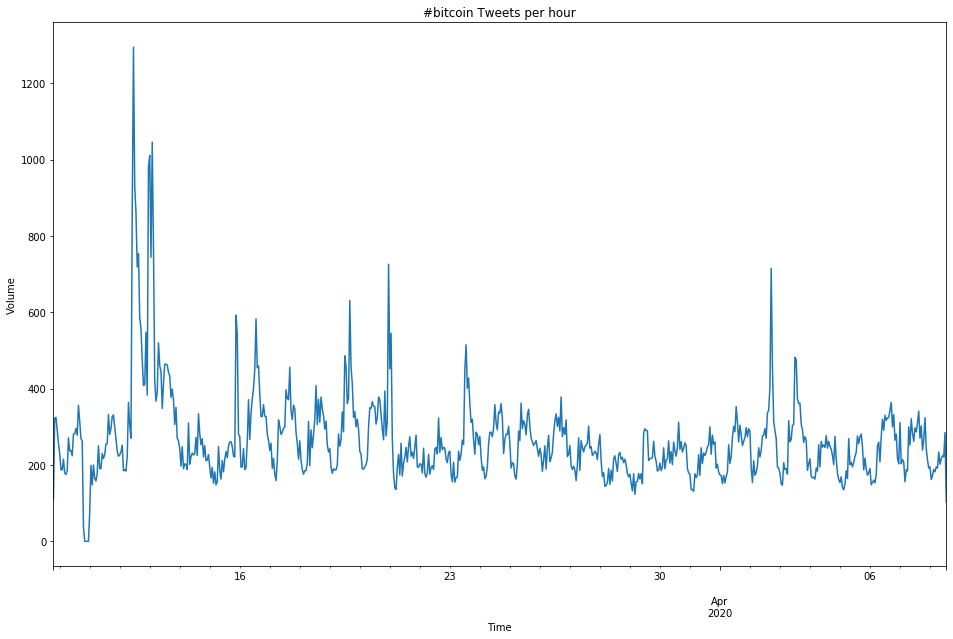

In [46]:
plot_start_date = '2020-03-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per hour')

### Google Trends Data

In [32]:
from pytrends.request import TrendReq

In [33]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df.tail()

,bitcoin
date,
2020-03-08,20
2020-03-15,20
2020-03-22,15
2020-03-29,13
2020-04-05,12


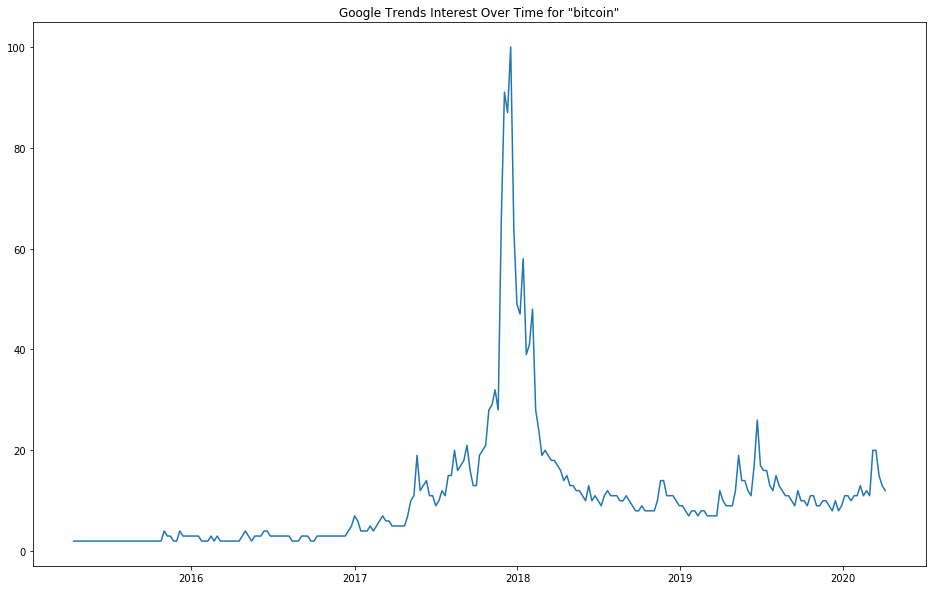

In [34]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [152]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2020, month_start=1, day_start=1, hour_start=0, year_end=2020, month_end=4, day_end=6, hour_end=0, cat=0, geo='', gprop='')
del historical_hourly_interest_df['isPartial']
historical_hourly_interest_df.head()

,bitcoin
date,
2020-01-01 00:00:00,49
2020-01-01 01:00:00,46
2020-01-01 02:00:00,0
2020-01-01 03:00:00,0
2020-01-01 04:00:00,0


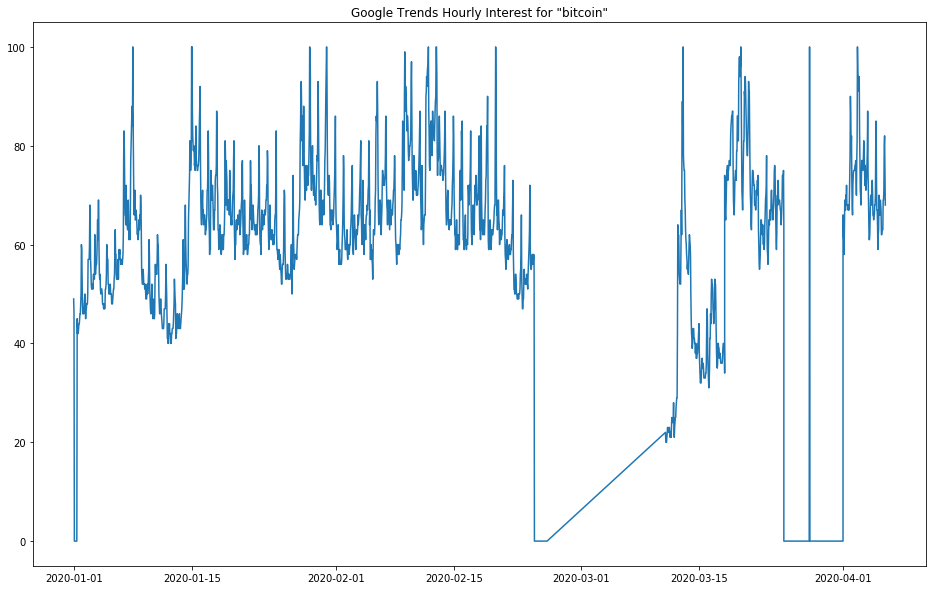

In [153]:
plot = plt.plot(historical_hourly_interest_df)
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

Some issues with this data.

### Bitcoin price data

In [37]:
import requests
from io import StringIO

In [53]:
btc_cb_data = requests.get('http://www.cryptodatadownload.com/cdd/Coinbase_BTCUSD_1h.csv').content.decode()
btc_bn_data = requests.get('http://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_1h.csv').content.decode()

btc_cb_df = pd.read_csv(StringIO(btc_cb_data), skiprows=1)
btc_bn_df = pd.read_csv(StringIO(btc_bn_data), skiprows=1)

btc_cb_df['Date'] = pd.to_datetime(btc_cb_df['Date'], format='%Y-%m-%d %I-%p')
btc_bn_df['Date'] = pd.to_datetime(btc_bn_df['Date'], format='%Y-%m-%d %I-%p')

In [56]:
btc_bn_df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT
0,2020-04-01 11:00:00,BTCUSDT,6291.71,6306.09,6276.56,6281.59,493.31,3102264.83
1,2020-04-01 10:00:00,BTCUSDT,6300.00,6320.10,6286.58,6291.71,2061.05,12987515.94
2,2020-04-01 09:00:00,BTCUSDT,6306.69,6314.30,6257.32,6300.00,2730.94,17170124.74
3,2020-04-01 08:00:00,BTCUSDT,6331.96,6331.96,6285.00,6306.69,2200.56,13872549.35
4,2020-04-01 07:00:00,BTCUSDT,6299.79,6337.96,6287.03,6331.96,2211.29,13970065.90


Text(0.5, 0.98, 'Bitcoin Historical Hourly Price Data')

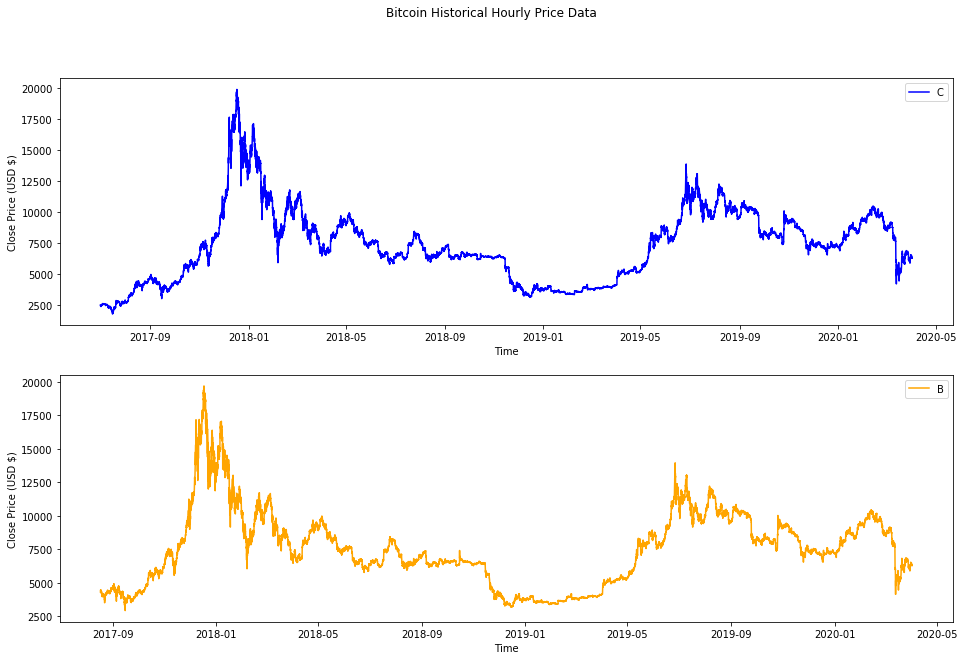

In [55]:
fig, ax =  plt.subplots(2,1)

ax[0].plot(btc_cb_df['Date'], btc_cb_df['Close'], color='blue')
ax[0].legend('Coinbase')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Close Price (USD $)')

ax[1].plot(btc_bn_df['Date'], btc_bn_df['Close'], color='orange')
ax[1].legend('Binance')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Close Price (USD $)')

fig.suptitle('Bitcoin Historical Hourly Price Data')

### TO DO: Deribit volatility data
(waiting for calculator)

### Tweet sentiment time series

In [41]:
sentiment_time = tweet_grouped.mean()
sentiment_time.head()

,sentiment_rating
created,
2020-03-09 19:00:00+00:00,0.303571
2020-03-09 20:00:00+00:00,0.295031
2020-03-09 21:00:00+00:00,0.083077
2020-03-09 22:00:00+00:00,0.182759
2020-03-09 23:00:00+00:00,0.186770


Text(0, 0.5, 'Mean Sentiment Rating')

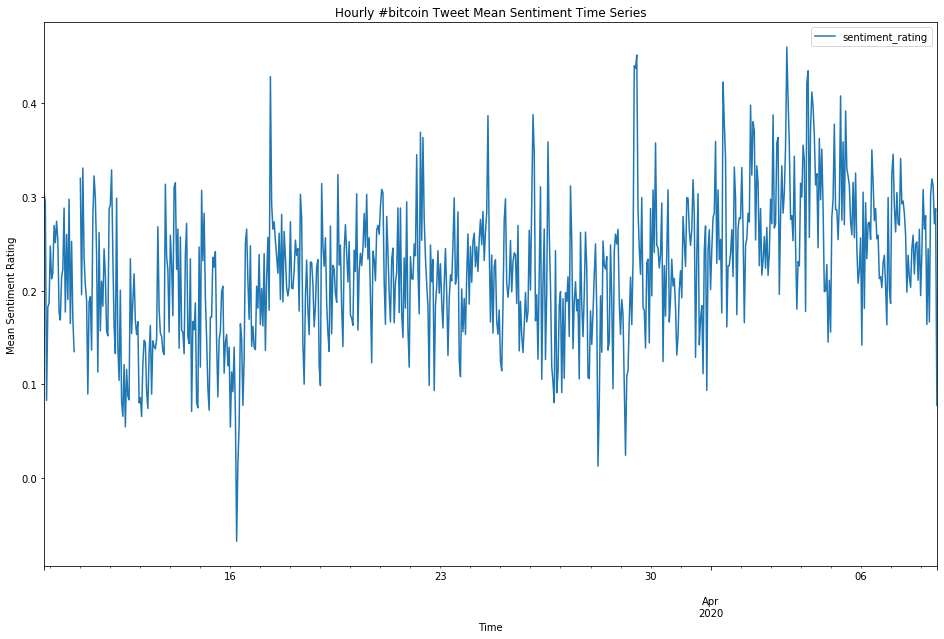

In [42]:
sentiment_time.plot()
plt.title('Hourly #bitcoin Tweet Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

## Try mean of compound instead of discrete ratings

***

## Regression Models

### Data Cleaning

Select a common time range where each series has clean data available:

In [121]:
start_date = '2020-03-10'
end_date = '2020-03-31'

series_btc = btc_cb_df.filter(['Date', 'Close']).set_index('Date').loc[start_date:end_date]
series_sentiment = sentiment_time.loc[start_date:end_date]
series_volume = tweet_volume.filter(['tweet_id']).loc[start_date:end_date]
series_gtrends = historical_hourly_interest_df.loc[start_date:end_date]

Plot narrowed down time series:

Text(0.5, 0.98, 'Time Series')

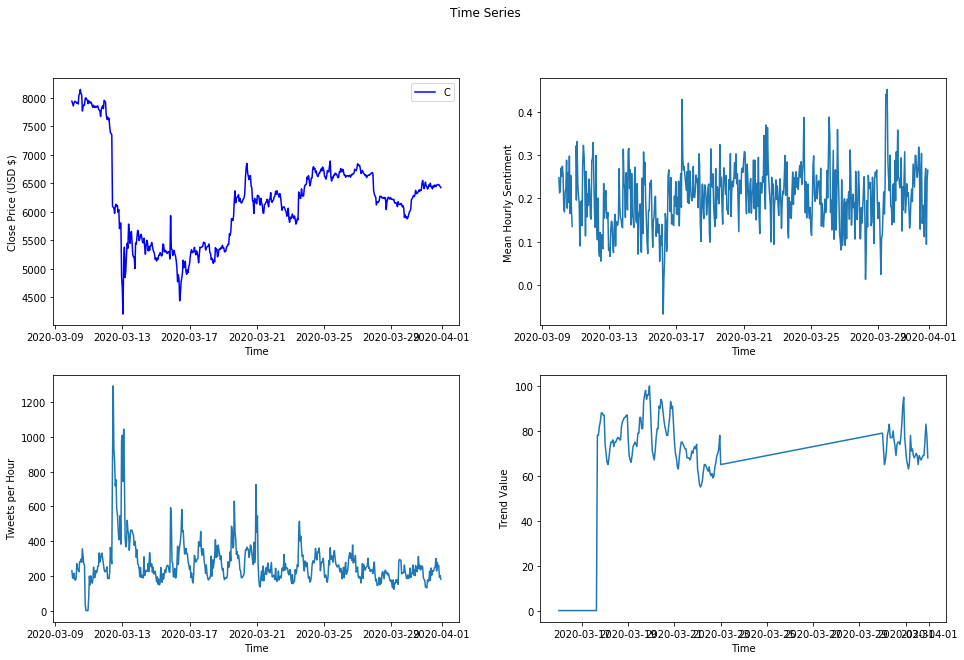

In [151]:
fig, ax =  plt.subplots(2,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Coinbase')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Close Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean Hourly Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per Hour')

ax[1][1].plot(series_gtrends)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Trend Value')

fig.suptitle('Time Series')

Discard Google Trends data for the time being. Need to determine what is causing the strange gaps.

In [ ]:
series_btc = series_btc.tz_localize('UTC', level=0)
series_volume = series_btc.tz_localize('UTC', level=0)

In [135]:
data = series_volume.merge(series_sentiment, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data.columns = ['Tweet Volume', 'Mean Sentiment', 'BTC Close']
data

,Tweet Volume,Mean Sentiment,BTC Close
2020-03-10 00:00:00+00:00,230,0.247826,7938.98
2020-03-10 01:00:00+00:00,188,0.212766,7899.99
2020-03-10 02:00:00+00:00,187,0.219251,7855.35
2020-03-10 03:00:00+00:00,215,0.269767,7909.15
2020-03-10 04:00:00+00:00,179,0.251397,7932.01
...,...,...,...
2020-03-31 19:00:00+00:00,254,0.244094,6474.20
2020-03-31 20:00:00+00:00,260,0.269231,6479.41
2020-03-31 21:00:00+00:00,192,0.093750,6460.14
2020-03-31 22:00:00+00:00,202,0.242574,6443.44


### Linear Regression?

In [136]:
X = data[['Tweet Volume', 'Mean Sentiment']]
Y = data['BTC Close']

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
print(linreg.intercept_)
print(linreg.coef_)
list(zip(['Tweet Volume', 'Mean Sentiment'], linreg.coef_))

6100.663704741147
[-1.07977768e+00  1.85927304e+03]


[('Tweet Volume', -1.0797776810257635), ('Mean Sentiment', 1859.27304259291)]

### Metrics

In [145]:
from sklearn import metrics

Y_pred = linreg.predict(X_test)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))

RMSE 753.2670706858613


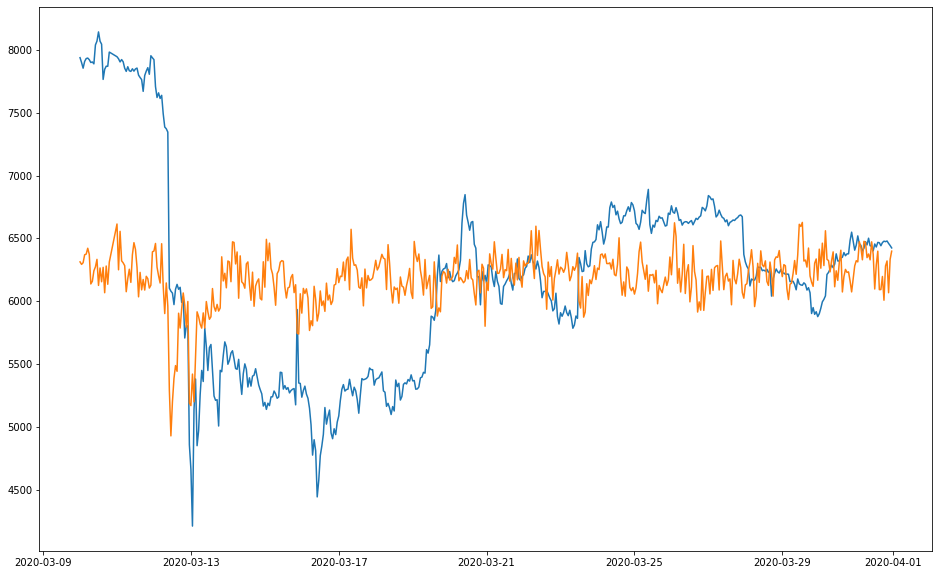

In [150]:
btc_pred = linreg.intercept_ + linreg.coef_[0] * data['Tweet Volume'] + linreg.coef_[1] * data['Mean Sentiment']

plt.plot(data['BTC Close'])
plt.plot(btc_pred)

## ARIMA